<a href="https://colab.research.google.com/github/Khanbir/Projekt_Otis/blob/main/Final_projekt_Khanbir_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

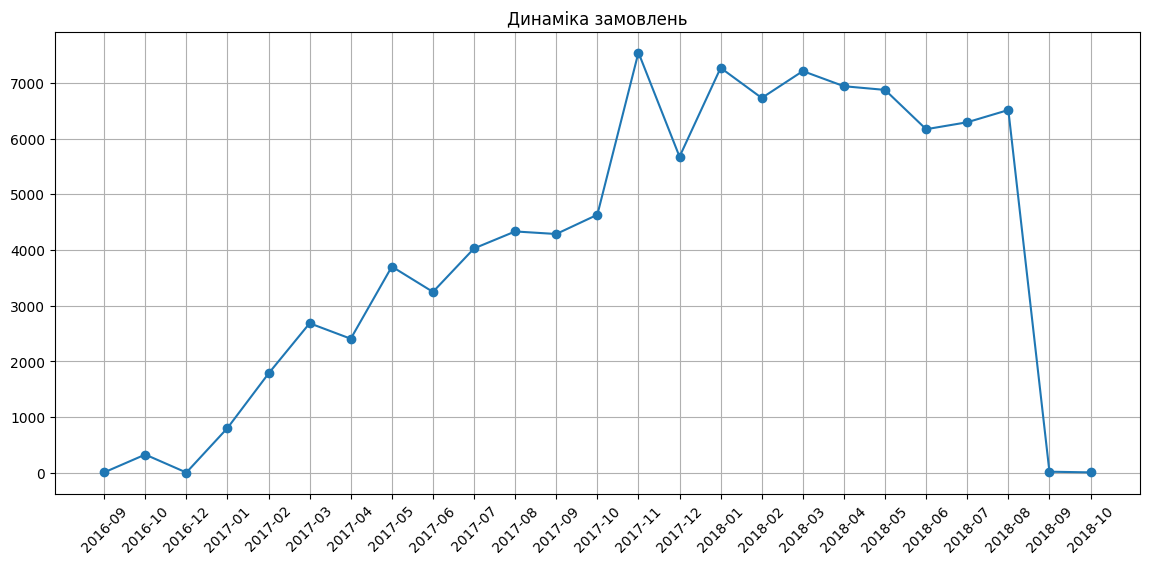

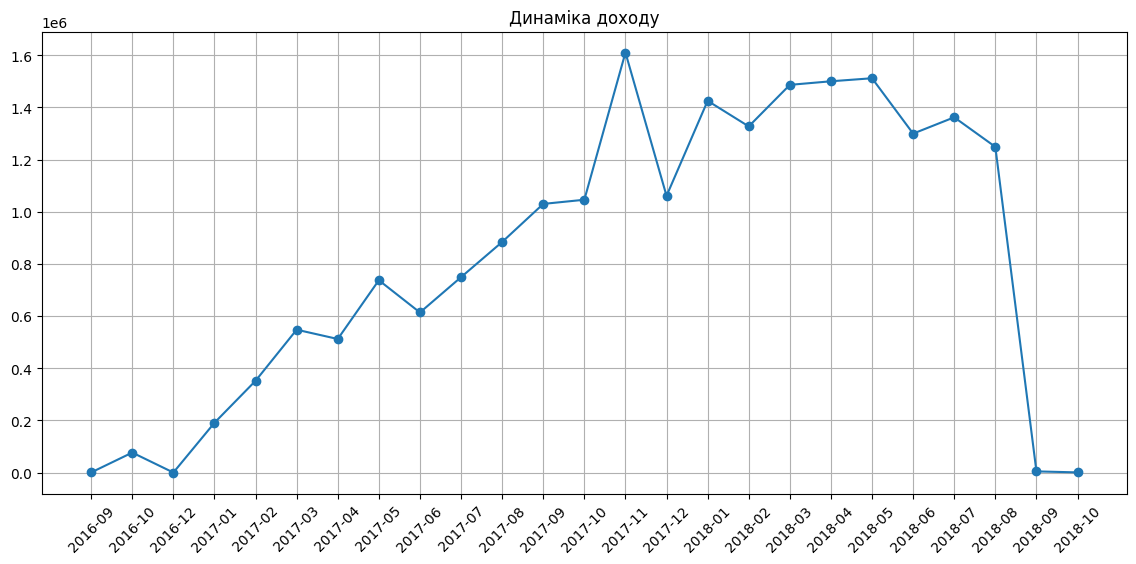

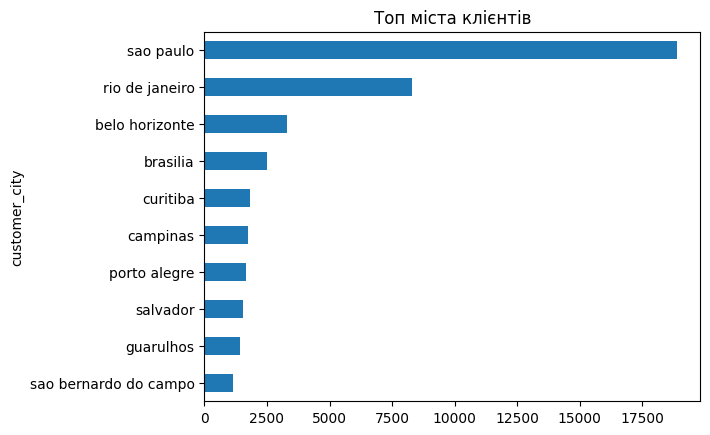

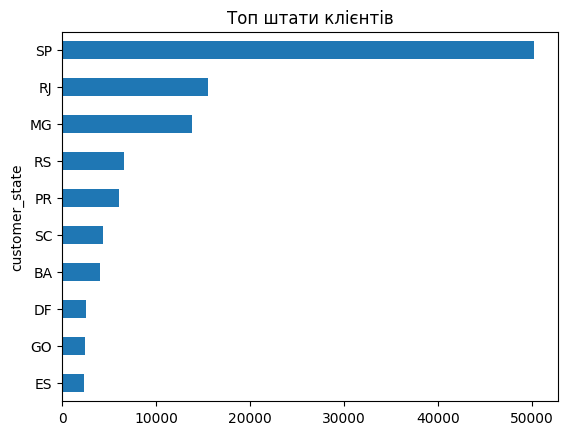

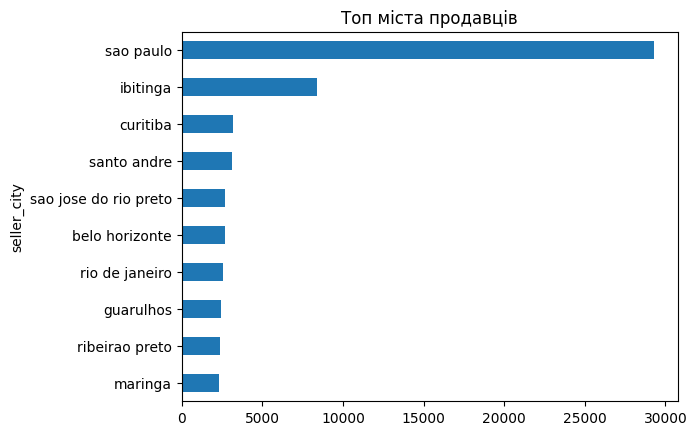

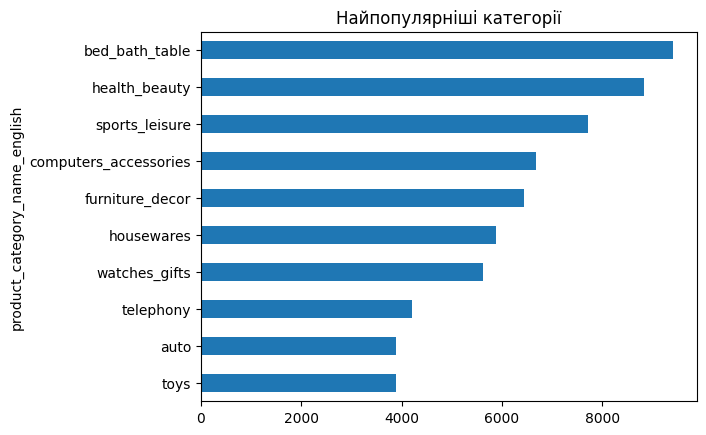

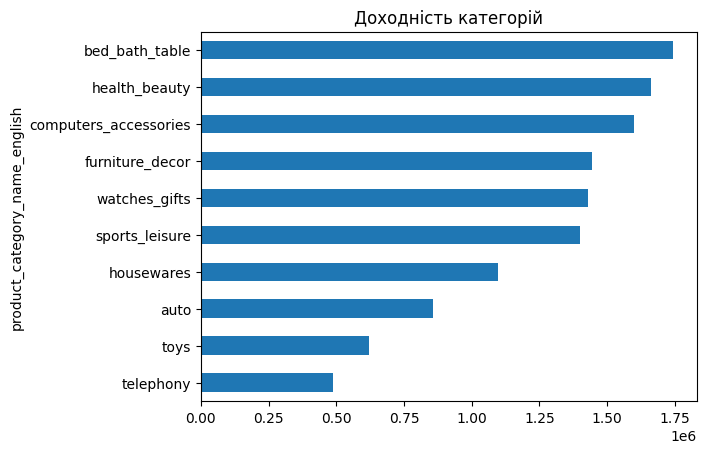

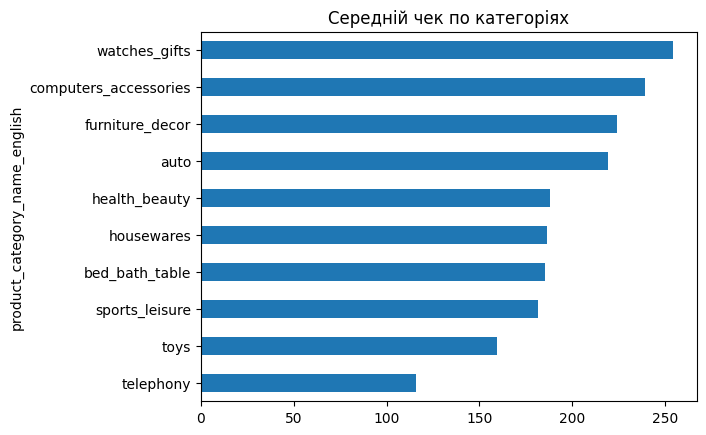

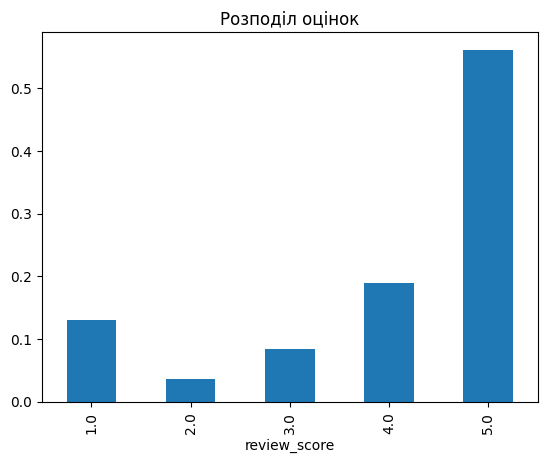

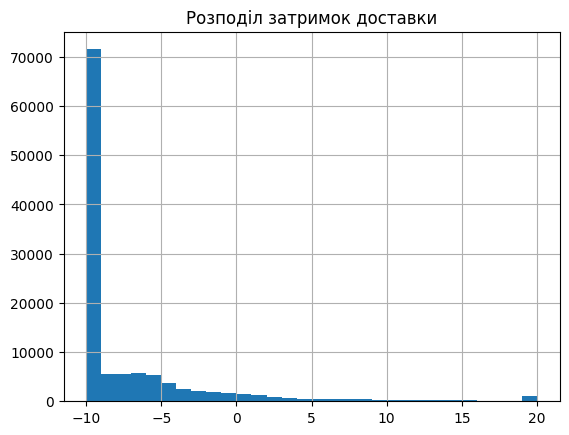

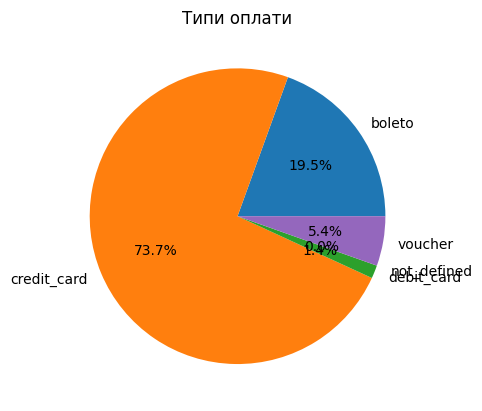

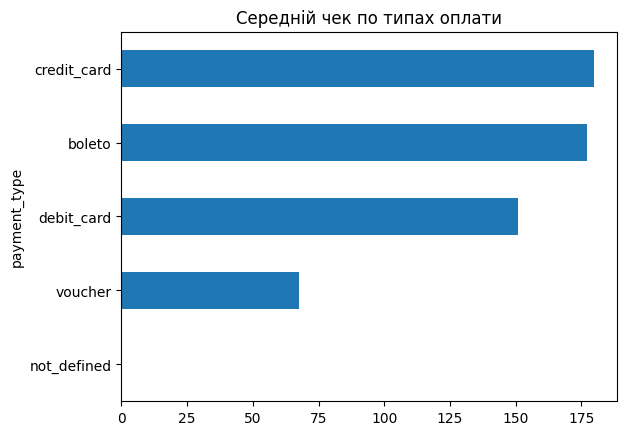

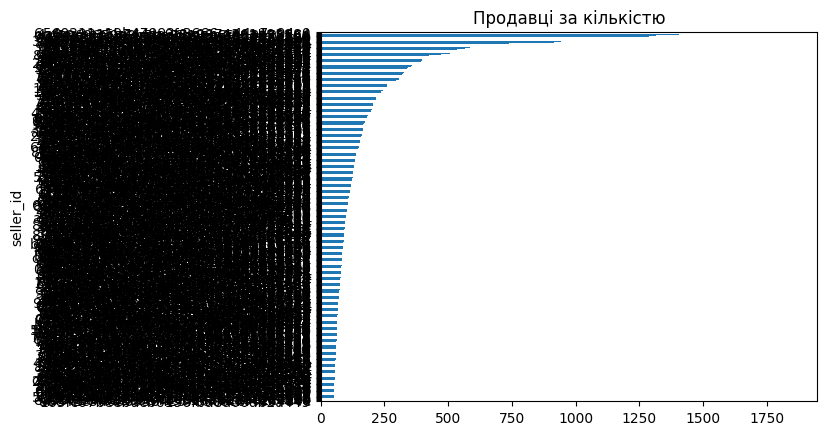

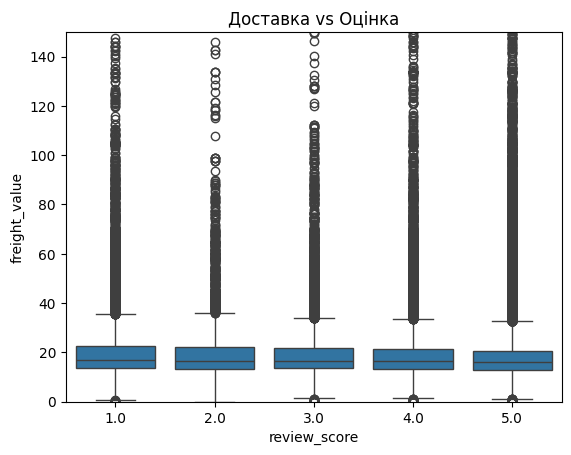

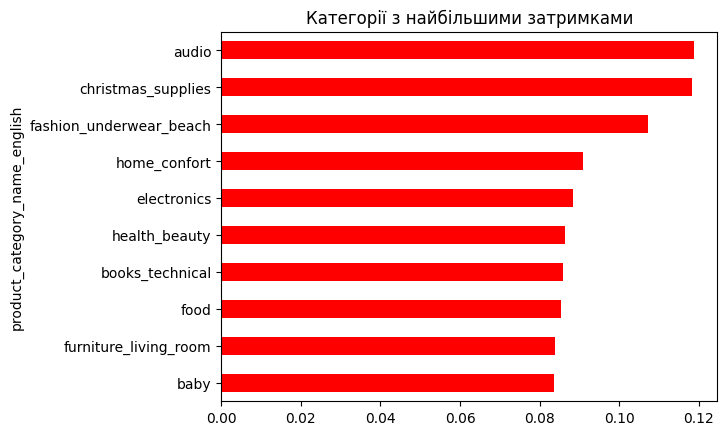

In [1]:
# Імпортуємо бібліотеки
# Імпорти
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Завантаження CSV-файлів
customers = pd.read_csv("/content/drive/MyDrive/DATA-ANALITICS_ Pylieva/ФІНАЛЬНИЙ ПРОЄКТ/olist_customers_dataset.csv")
geolocation = pd.read_csv("/content/drive/MyDrive/DATA-ANALITICS_ Pylieva/ФІНАЛЬНИЙ ПРОЄКТ/olist_geolocation_dataset.csv")
order_items = pd.read_csv("/content/drive/MyDrive/DATA-ANALITICS_ Pylieva/ФІНАЛЬНИЙ ПРОЄКТ/olist_order_items_dataset.csv")
order_payments = pd.read_csv("/content/drive/MyDrive/DATA-ANALITICS_ Pylieva/ФІНАЛЬНИЙ ПРОЄКТ/olist_order_payments_dataset.csv")
order_reviews = pd.read_csv("/content/drive/MyDrive/DATA-ANALITICS_ Pylieva/ФІНАЛЬНИЙ ПРОЄКТ/olist_order_reviews_dataset.csv")
orders = pd.read_csv("/content/drive/MyDrive/DATA-ANALITICS_ Pylieva/ФІНАЛЬНИЙ ПРОЄКТ/olist_orders_dataset.csv")
products = pd.read_csv("/content/drive/MyDrive/DATA-ANALITICS_ Pylieva/ФІНАЛЬНИЙ ПРОЄКТ/olist_products_dataset.csv")
sellers = pd.read_csv("/content/drive/MyDrive/DATA-ANALITICS_ Pylieva/ФІНАЛЬНИЙ ПРОЄКТ/olist_sellers_dataset.csv")
category_translation = pd.read_csv("/content/drive/MyDrive/DATA-ANALITICS_ Pylieva/ФІНАЛЬНИЙ ПРОЄКТ/product_category_name_translation.csv")

# Злиття
df = orders.merge(order_items, on="order_id", how="left")\
          .merge(order_payments, on="order_id", how="left")\
          .merge(order_reviews, on="order_id", how="left")\
          .merge(products, on="product_id", how="left")\
          .merge(category_translation, on="product_category_name", how="left")\
          .merge(sellers, on="seller_id", how="left")\
          .merge(customers, on="customer_id", how="left")

df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])

# Експорт загальної таблиці - при обновленні а зміні даних повторити
# df.to_csv("/content/drive/MyDrive/DATA-ANALITICS_ Pylieva/ФІНАЛЬНИЙ ПРОЄКТ/tableau_merged_data.csv", index=False)


# Аналіз 1: Продажі по місяцях
df['order_month'] = df['order_purchase_timestamp'].dt.to_period('M').astype(str)
monthly = df.groupby('order_month').agg({
    'order_id': 'nunique',
    'payment_value': 'sum'
}).rename(columns={'order_id': 'total_orders', 'payment_value': 'total_revenue'}).reset_index()

plt.figure(figsize=(14, 6))
plt.plot(monthly['order_month'], monthly['total_orders'], marker='o')
plt.xticks(rotation=45)
plt.title("Динаміка замовлень")
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(monthly['order_month'], monthly['total_revenue'], marker='o')
plt.xticks(rotation=45)
plt.title("Динаміка доходу")
plt.grid(True)
plt.show()

# Аналіз 2: Географія
df['customer_city'].value_counts().head(10).sort_values().plot(kind='barh')
plt.title("Топ міста клієнтів")
plt.show()

df['customer_state'].value_counts().head(10).sort_values().plot(kind='barh')
plt.title("Топ штати клієнтів")
plt.show()

df['seller_city'].value_counts().head(10).sort_values().plot(kind='barh')
plt.title("Топ міста продавців")
plt.show()

# Аналіз 3: Категорії
cat = df.groupby('product_category_name_english').agg({
    'order_id': 'nunique',
    'payment_value': 'sum'
}).rename(columns={'order_id': 'total_orders', 'payment_value': 'total_revenue'})
cat['avg'] = cat['total_revenue'] / cat['total_orders']
top = cat.sort_values(by='total_orders', ascending=False).head(10)

top['total_orders'].sort_values().plot(kind='barh')
plt.title("Найпопулярніші категорії")
plt.show()

top['total_revenue'].sort_values().plot(kind='barh')
plt.title("Доходність категорій")
plt.show()

top['avg'].sort_values().plot(kind='barh')
plt.title("Середній чек по категоріях")
plt.show()

# Аналіз 4: Оцінки
df['review_score'].value_counts(normalize=True).sort_index().plot(kind='bar')
plt.title("Розподіл оцінок")
plt.show()

# Аналіз 5: Час доставки
df_d = df.dropna(subset=['order_delivered_customer_date', 'order_estimated_delivery_date']).copy()
df_d['actual'] = (df_d['order_delivered_customer_date'] - df_d['order_purchase_timestamp']).dt.days
df_d['expected'] = (df_d['order_estimated_delivery_date'] - df_d['order_purchase_timestamp']).dt.days
df_d['delay'] = df_d['actual'] - df_d['expected']

df_d['delay'].clip(-10, 20).hist(bins=30)
plt.title("Розподіл затримок доставки")
plt.show()

# Аналіз 6: Типи оплат
pay = df.groupby('payment_type').agg({
    'payment_value': ['count', 'mean']
})
pay.columns = ['transactions', 'avg_payment']

pay['transactions'].plot.pie(autopct='%1.1f%%')
plt.title("Типи оплати")
plt.ylabel("")
plt.show()

pay['avg_payment'].sort_values().plot(kind='barh')
plt.title("Середній чек по типах оплати")
plt.show()

# Аналіз 7: Продавці
sellers = df.groupby('seller_id').agg({
    'order_id': 'nunique',
    'payment_value': 'mean',
    'review_score': 'mean'
}).rename(columns={
    'order_id': 'order_count',
    'payment_value': 'avg_order_value',
    'review_score': 'avg_review_score'
})
sellers = sellers[sellers['order_count'] >= 50]

sellers['order_count'].sort_values().plot(kind='barh')
plt.title("Продавці за кількістю")
plt.show()

# Аналіз 8: Вартість доставки та оцінки
sns.boxplot(x='review_score', y='freight_value', data=df.dropna(subset=['freight_value', 'review_score']))
plt.ylim(0, 150)
plt.title("Доставка vs Оцінка")
plt.show()

# Аналіз 9: Затримки
df_d['is_late'] = df_d['delay'] > 0
late_by_cat = df_d.groupby('product_category_name_english').agg({'is_late': ['mean', 'count']})
late_by_cat.columns = ['late_ratio', 'count']
late_by_cat = late_by_cat[late_by_cat['count'] >= 100].sort_values(by='late_ratio', ascending=False).head(10)

late_by_cat['late_ratio'].sort_values().plot(kind='barh', color='red')
plt.title("Категорії з найбільшими затримками")
plt.show()
